In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

import matplotlib.pyplot as plt
plt.tight_layout()
import time

from IPython import display
import seaborn as sns
sns.set_style("darkgrid")


In [2]:
INPUT_LAYER = 28*28
HIDDEN_LAYER = 512
OUTPUT_LAYER = 10

class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_LAYER, HIDDEN_LAYER)
        self.fc2 = nn.Linear(HIDDEN_LAYER, OUTPUT_LAYER)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [3]:
# Load MNIST data (Handwritten Digits)
batch_size = 100
from torchvision import datasets, transforms
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

In [4]:
#Initialise the Neural Network on GPU
model = FCN().cuda()

In [5]:
loss_fn = torch.nn.MSELoss(size_average=False)

In [6]:
# Helper Classes
class ComputeAccuracy:
    def __init__(self):
        self.history = []
        self.correct = 0
        self.total = 0
        
    def update(self, predicted_labels, true_labels):
        correct = sum(true_labels == predicted_labels)
        accuracy = np.float(correct)/len(predicted_labels)
        self.history.append(accuracy*100)
        self.correct += correct
        self.total += len(predicted_labels)
        


def one_hot(batch_size , labels):
    labels = torch.LongTensor(labels).view(batch_size, 1)
    one_hot = torch.zeros(batch_size, 10)
    one_hot.scatter_(1, labels, 1)
    return one_hot


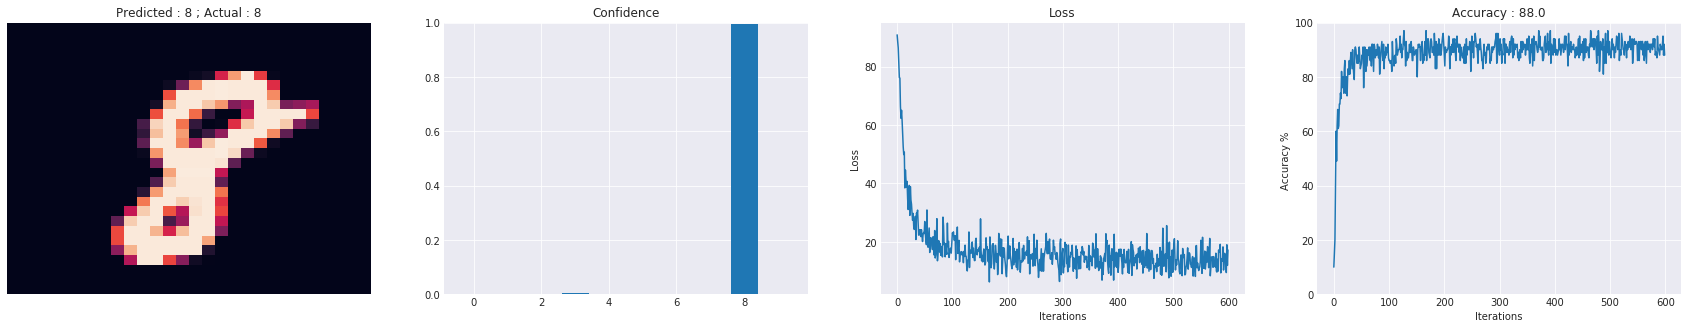

In [7]:
learning_rate = 0.001
accuracy_history = ComputeAccuracy()        
loss_history = []

model.train()


for batch_idx, (images, true_labels) in enumerate(train_loader):
    """
        Reshape data to be "compatible" with our network
    """
    reshaped_data = images.view(batch_size, INPUT_LAYER)
    
    # Do the actual prediction
    _input = Variable(reshaped_data.cuda())
    output = model(_input)
    max_confidences, predictions = output.max(1)
        
    true_labels = true_labels.cpu().numpy()
    predictions = predictions.data.cpu().numpy()
    

    # Update accuracy history
    accuracy_history.update(predictions, true_labels)
    
    one_hot_encoded_true_labels = Variable(one_hot(batch_size, true_labels).cuda())
        
    loss = loss_fn(output, one_hot_encoded_true_labels)
    if batch_idx % 1 == 0:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(30,5))

        """
        Plot actual Image
        """
        _d = images[0].cpu().numpy()[0]
        ax1.set_title("Predicted : {} ; Actual : {}".format(predictions[0], true_labels[0]))
        sns.heatmap(_d, xticklabels=False, yticklabels=False, cbar=False, ax=ax1)
        
        
        """
        Plot prediction probabilities
        """
        ax2.set_title("Confidence")
        ax2.set_ylim(bottom=0, top=1)
        ax2.bar(np.arange(10), output[0].data.cpu().numpy())
        
        """
        Plot history
        """
        loss_history.append(loss.data[0])
        ax3.set_title("Loss")
        ax3.set_xlabel("Iterations")
        ax3.set_ylabel("Loss")
        ax3.plot(loss_history)
        
        """
        Plot Accuracy
        """
        ax4.set_title("Accuracy : {}".format(accuracy_history.history[-1]))
        ax4.set_xlabel("Iterations")
        ax4.set_ylabel("Accuracy % ")
        ax4.set_ylim(bottom=0, top=100)
        ax4.plot(accuracy_history.history)
        
        display.clear_output(wait=True)        
        plt.show()
    
    
    
    
    model.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data
    
    if batch_idx > 10000:
        break    
    

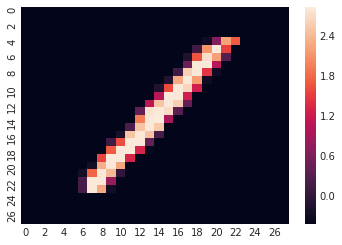

In [16]:
images, true_labels = next(iter(train_loader))
_d = images[0].cpu().numpy()[0]
sns.heatmap(_d)

In [17]:
reshaped_data = images[0].view(1, INPUT_LAYER)
output = model(Variable(reshaped_data.cuda()))
prediction = np.argmax(output.data.cpu().numpy())

print(prediction)

1
